In [23]:
import importlib
import micasense.capture
import cv2
import os, glob
import json
import pickle #This library will maintain the format as well
from osgeo import gdal,osr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import PIL.Image as Image
import datetime
from math import ceil
from tqdm import tqdm
import re
import glob
from PIL import Image
import contextlib

import algorithms.flight_attributes
import algorithms.validate_algorithm
import algorithms.select_GPS as SelectGPS
import algorithms.georeferencing
import algorithms.alignment_error
import algorithms.plot_map
import algorithms.mutils as mutils

importlib.reload(algorithms.flight_attributes)
importlib.reload(algorithms.georeferencing)
importlib.reload(algorithms.alignment_error)
importlib.reload(algorithms.plot_map)

import algorithms.flight_attributes as FlightAttributes
import algorithms.georeferencing as georeferencing
import algorithms.alignment_error as alignment_error
import algorithms.plot_map as plot_map

In [2]:
sw_point = (1.319010, 103.736650)
ne_point = (1.319806, 103.737532)

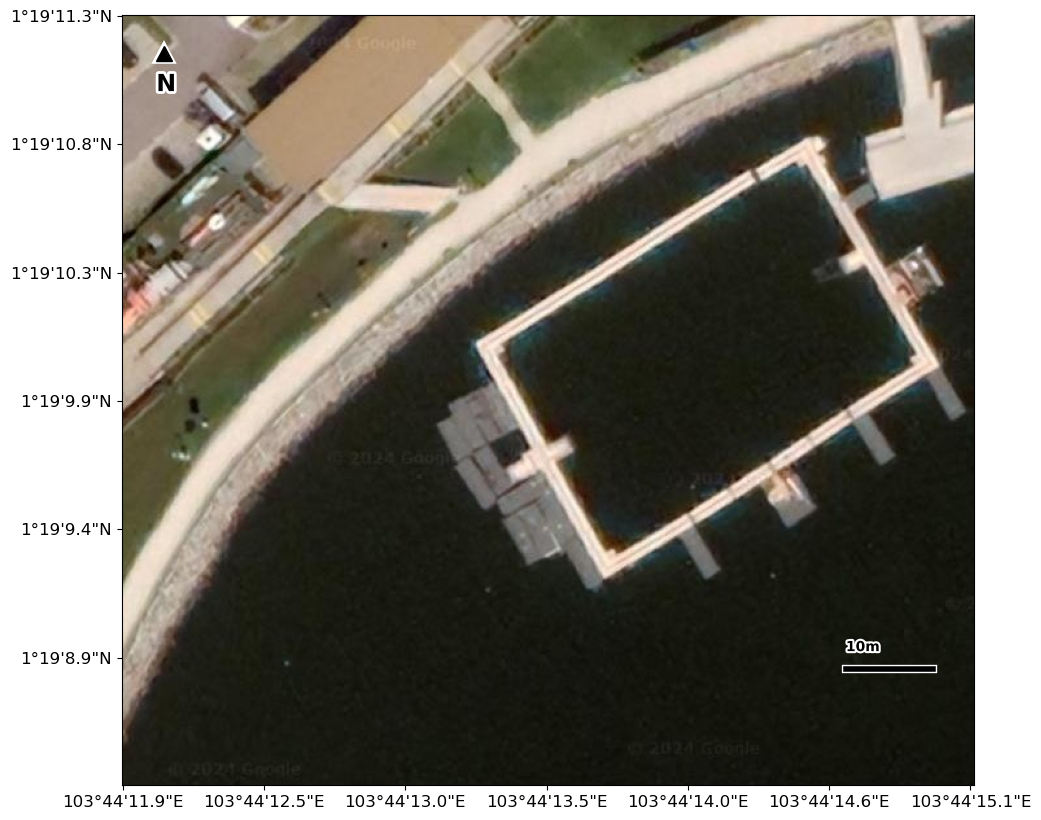

In [3]:
img = np.asarray(Image.open(r"plots\aerialbot-2024-01-22T12.25.29-downward-1.319335,103.737142-2000x2000m-z20.jpg"))

PM = plot_map.PlotMap(ne_point,sw_point,img)
PM.plot()

In [4]:
imagePath = r"D:\EPMC_flight\pandanRes\00angle_15H_50overlap"
rawImagePath = os.path.join(imagePath,'RawImg') # We created a new folder called RawImg to store all the raw images here
flightAttributesPath = os.path.join(imagePath,'flight_attributes','flight_attributes.csv')
if os.path.exists(flightAttributesPath):
    log = pd.read_csv(flightAttributesPath)
log.head()
flight_points = SelectGPS.readSelectedGPS(rawImagePath)
height_dict = FlightAttributes.get_heights(imagePath,log)
height_min = height_dict['height_min']

[10, 15, 19, 25, 29, 35, 39, 45, 49, 55, 59, 65]
offset height: 26m


In [5]:
DEM_offset_height = height_min
df_cropped = log.iloc[flight_points,:]
#----------------append flight angle---------------------------------------------
df_cropped.loc[:,['flight_angle']] = -df_cropped['dls-yaw']/np.pi*180
#-----------adjust UAV's altitude instead of using GPS's altitude reading--------
df_cropped.loc[:,['altitude']] = df_cropped.loc[:,['altitude']] - DEM_offset_height
# ---- instead of using yaw, use the heading of the UAV----------
reclassify_angles = lambda x: -180 if x < -160 else 0
reclassified_angles = [reclassify_angles(i) for i in df_cropped['flight_angle'].to_list()]
df_cropped.loc[:,['flight_angle']] = reclassified_angles
#----------------------------------------------------------------

In [6]:
PG = FlightAttributes.PlotGeoreference(imagePath,df_cropped)
geotransform_list = PG.get_flight_attributes()
print(geotransform_list)

{10: {'lat': 1.3192234, 'lon': 103.7368554, 'lat_res': 1.0628677378960366e-07, 'lon_res': 1.0631495350475142e-07, 'flight_angle': 0.0, 'image_fp': 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0010_1.jpg'}, 11: {'lat': 1.3192848, 'lon': 103.7368553, 'lat_res': 1.0702656078197768e-07, 'lon_res': 1.070549392781877e-07, 'flight_angle': 0.0, 'image_fp': 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0011_1.jpg'}, 12: {'lat': 1.3193286, 'lon': 103.7368548, 'lat_res': 1.0623219933934656e-07, 'lon_res': 1.0626036907840427e-07, 'flight_angle': 0.0, 'image_fp': 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0012_1.jpg'}, 13: {'lat': 1.3193714, 'lon': 103.7368543, 'lat_res': 1.0572283780361363e-07, 'lon_res': 1.0575087429393181e-07, 'flight_angle': 0.0, 'image_fp': 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0013_1.jpg'}, 14: {'lat': 1.3194217, 'lon': 103.736854, 'lat_res': 1.0521954009568703e-07, 'lon_res': 

[]

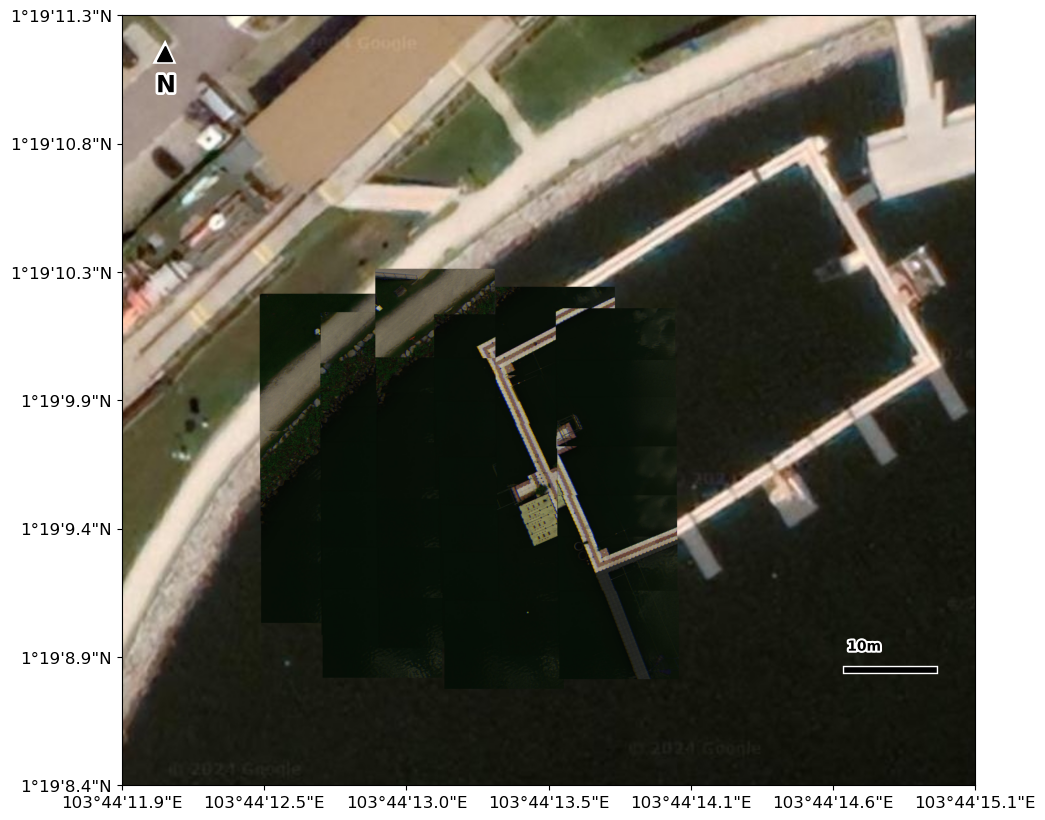

In [7]:
canvas = np.asarray(Image.open(r"plots\aerialbot-2024-01-22T12.25.29-downward-1.319335,103.737142-2000x2000m-z20.jpg"))
GR = plot_map.GeoreferenceRaster(ne_point,sw_point,canvas,geotransform_list)
GR.plot()

In [21]:
def makeGif(gifParentDir,fileName):
    # gifParentDir = os.path.join(os.path.dirname(imagePath),"images")
    # filepaths
    fp_in = os.path.join(gifParentDir,f'*.png') #"/path/to/image_*.png"
    imgDir = os.path.dirname(gifParentDir)
    gifDir = os.path.join(imgDir,"gif")
    os.mkdir(gifDir) if not os.path.exists(gifDir) else None
    fp_out = os.path.join(gifDir,f'{fileName}.gif')#"/path/to/image.gif"

    # use exit stack to automatically close opened images
    with contextlib.ExitStack() as stack:

            # lazily load images
            imgs = (stack.enter_context(Image.open(f))
                    for f in sorted(glob.glob(fp_in)))

            # extract  first image from iterator
            img = next(imgs)

            # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
            img.save(fp=fp_out, format='GIF', append_images=imgs,
                    save_all=True, duration=200, loop=0)

class BatchCorrect:
    def __init__(self,imagePath,dirName):
        """ 
        :param imagePath (str): directory to image folder
        :param dirName (str): name of directory folder
        """
        self.imagePath = imagePath
        self.rawImagePath = os.path.join(imagePath,'RawImg')
        self.flightAttributesPath = os.path.join(imagePath,'flight_attributes','flight_attributes.csv')
        self.log = pd.read_csv(self.flightAttributesPath)
        self.height_dict = FlightAttributes.get_heights(imagePath,self.log)
        self.flight_points = SelectGPS.readSelectedGPS(self.rawImagePath)
        self.dirName = dirName
    
    def save_data(self,dirPath,fileName, data):
        save_fp = os.path.join(dirPath,f'{fileName}.ob')
        with open(save_fp,'wb') as fp:
            pickle.dump(data,fp)
        return

    def get_distance_interpolation(self,interpolate_distance = 0.01,pad_distance = 1.5):
        IC = FlightAttributes.InterpolateCoordinates(self.log, 
                                interpolate_distance=interpolate_distance, 
                                pad_distance=pad_distance)
        interp_dist_dict = IC.get_interpolated_dict()
        self.interp_dist_dict = interp_dist_dict
        self.IC = IC
        return interp_dist_dict
    
    def shift_coord(self, shift_n):
        df_interpolated = self.IC.shift_coord(self.interp_dist_dict, shift_n=shift_n)
        # crop df based on selected flight points
        df_cropped = df_interpolated.iloc[self.flight_points,:]
        return df_cropped
    
    def get_geotransform(self,df_cropped):
        PG = FlightAttributes.PlotGeoreference(self.imagePath,df_cropped)
        geotransform_list = PG.get_flight_attributes()
        return geotransform_list

    def georeference_UAV(self,ne_point,sw_point,canvas, df_cropped, calculate_correlation=False):
        """ 
        returns the canvas with the UAV images plotted on top of it,
        and correlation coefficient of each image with the canvas
        """
        self.ne = ne_point
        self.sw = sw_point
        geotransform_list = self.get_geotransform(df_cropped)
        GR = plot_map.GeoreferenceRaster(ne_point,sw_point,canvas,geotransform_list)
        im_display, cc_list = GR.georeference_UAV(calculate_correlation=calculate_correlation)
        return im_display, cc_list
    
    def main_shiftCoord(self, modify_df,ne_point,sw_point,canvas, calculate_correlation=True):
        """ 
        :param modify_df (func): modify_df is a function to import an external function to modify the df
        """
        height_steps = 6
        dist1 = 0
        dist2 = 70
        n_fig = 8
        tickFontSize = 7
        tick_breaks = 4
        NorthFontSize = 7
        triangleFontSize = 5
        scaleBarFontSize = 8
        scaleBarWidth = 3

        self.get_distance_interpolation()

        height_dict = dict()
        for height in range(height_steps): # try offsets in height of up to 5m by 1meters
            DEM_offset_height = self.height_dict['DEM_offset_height'] - height
            
            shift_n_dict = dict()

            fig, axes = plt.subplots(2,ceil(n_fig/2), figsize=(16,7))

            for i, (shift_n , ax) in enumerate(zip(np.linspace(dist1,dist2,n_fig,dtype=int),axes.flatten())):
                df_cropped = self.shift_coord(shift_n)
                df_cropped = modify_df(df_cropped, DEM_offset_height)
                im_display, cc_list = self.georeference_UAV(ne_point, sw_point, canvas, 
                                                            df_cropped, 
                                                            calculate_correlation)
                shift_n_dict[shift_n] = cc_list
                PM = plot_map.PlotMap(ne_point,sw_point,im_display)
                PM.plot(ax=ax,add_ticks=False,add_compass=False,add_scale_bar=False)
                
                # set compass
                PM.add_compass(ax=ax,fontsize_N=NorthFontSize,fontsize_triangle=triangleFontSize)
                # set north
                PM.add_scale_bar(ax=ax,fontsize=scaleBarFontSize,lw=scaleBarWidth)
                # set subfigure title
                subfig_title = chr(ord('a') + i)
                ax.set_title(f'({subfig_title}) Shift: {shift_n}')
                
                # add ticks for border plots
                if i == 0:
                    PM.add_ticks(ax=ax,fontsize=tickFontSize,tick_breaks=tick_breaks,add_xticks=False)
                elif i == n_fig//2:
                    PM.add_ticks(ax=ax,fontsize=tickFontSize,tick_breaks=tick_breaks)
                elif i > n_fig//2:
                    PM.add_ticks(ax=ax,fontsize=tickFontSize,tick_breaks=tick_breaks,add_yticks=False)
                else:
                    PM.add_ticks(ax=ax,fontsize=tickFontSize,tick_breaks=tick_breaks,add_yticks=False, add_xticks= False)

            # add fig title
            correctedHeight = int(self.height_dict['measuredHeight'] - DEM_offset_height)
            fig.suptitle(f"Height: {self.height_dict['actualHeight']}m, Corrected height: {correctedHeight}m")
            plt.tight_layout()
            plt.show()

            # save cc list
            height_dict[correctedHeight] = shift_n_dict

            # save fig
            parentDir = os.path.join(self.imagePath,"images",self.dirName)
            os.mkdir(parentDir) if not os.path.exists(parentDir) else None
            fname = os.path.join(parentDir,f'offsetHeight{int(DEM_offset_height)}.png')
            fig.savefig(fname)

        # save cc list on disk
        self.save_data(parentDir,'cc_list',height_dict)
        
        # create gifs
        makeGif(parentDir,self.dirName)


offset height: 26m
[10, 15, 19, 25, 29, 35, 39, 45, 49, 55, 59, 65]


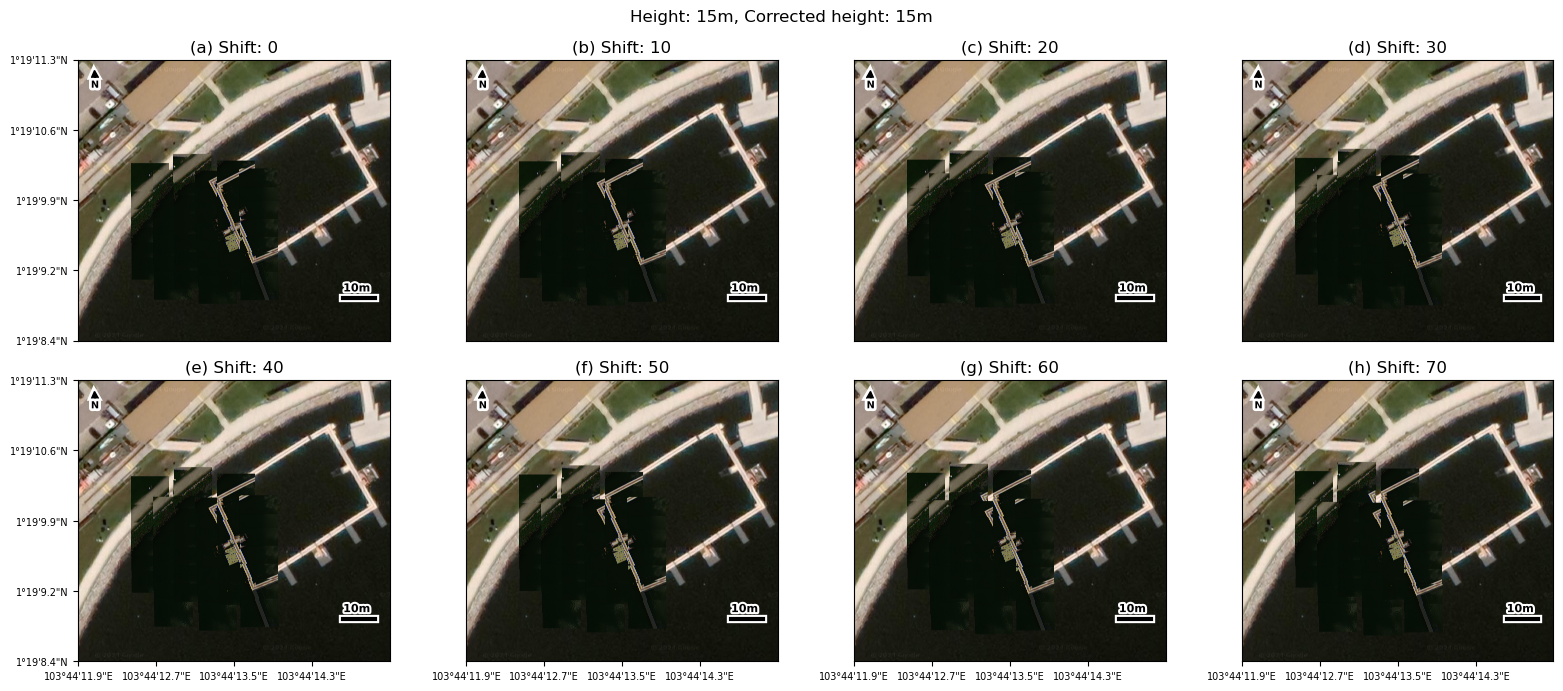

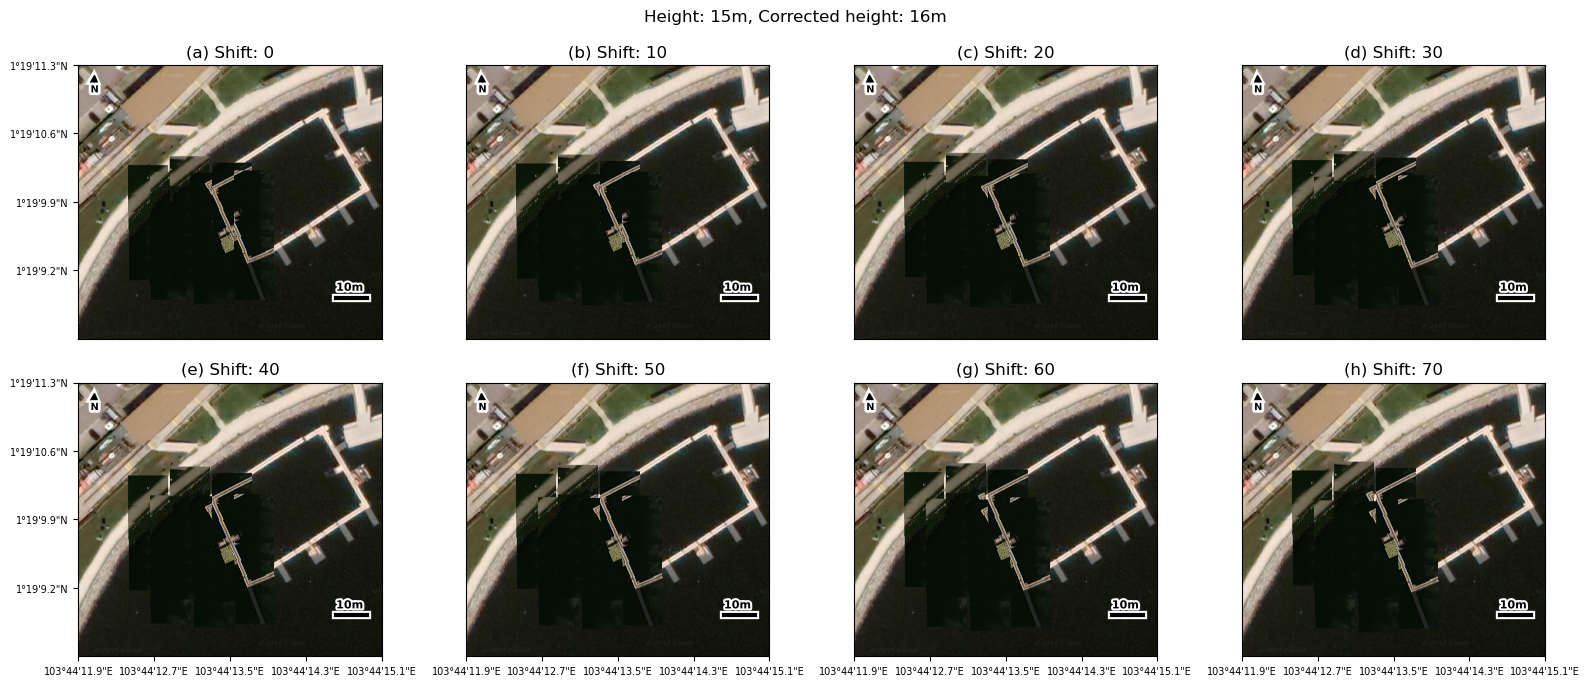

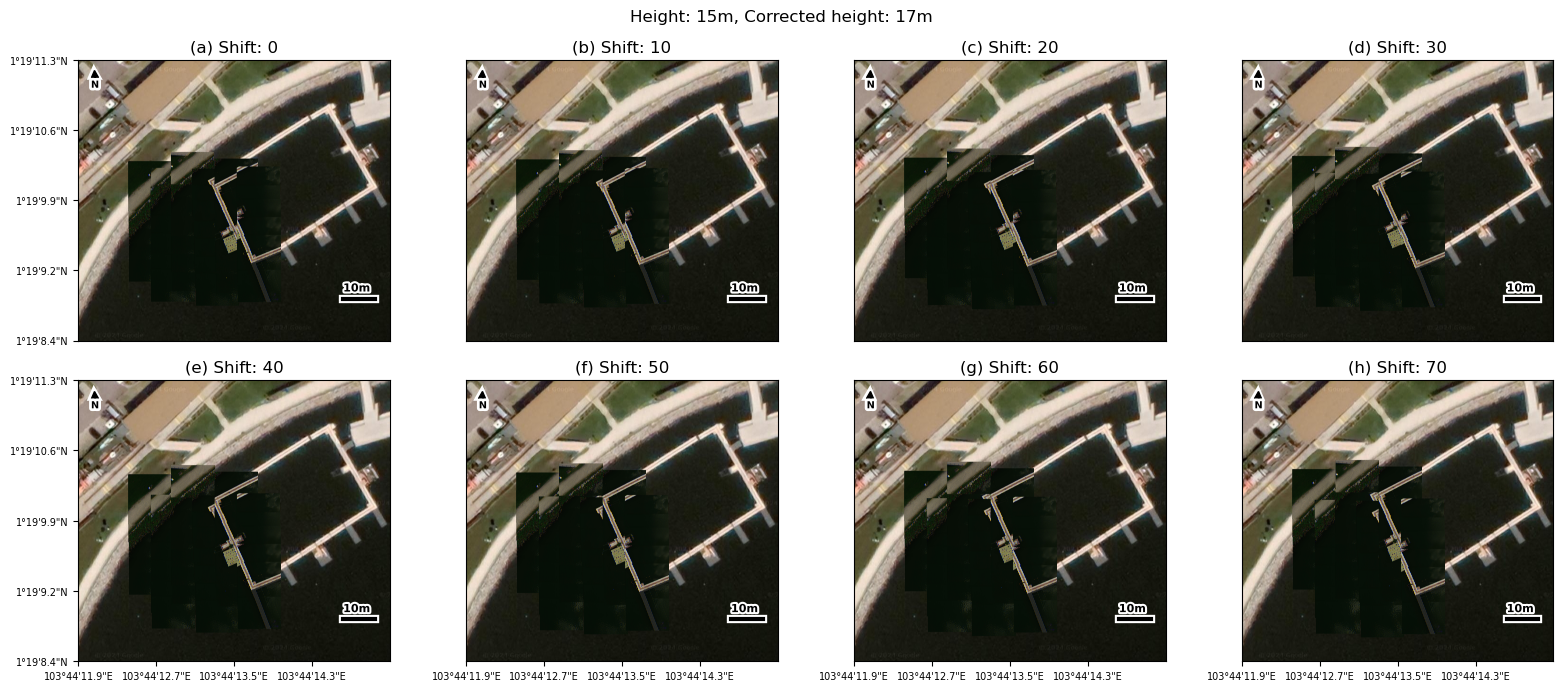

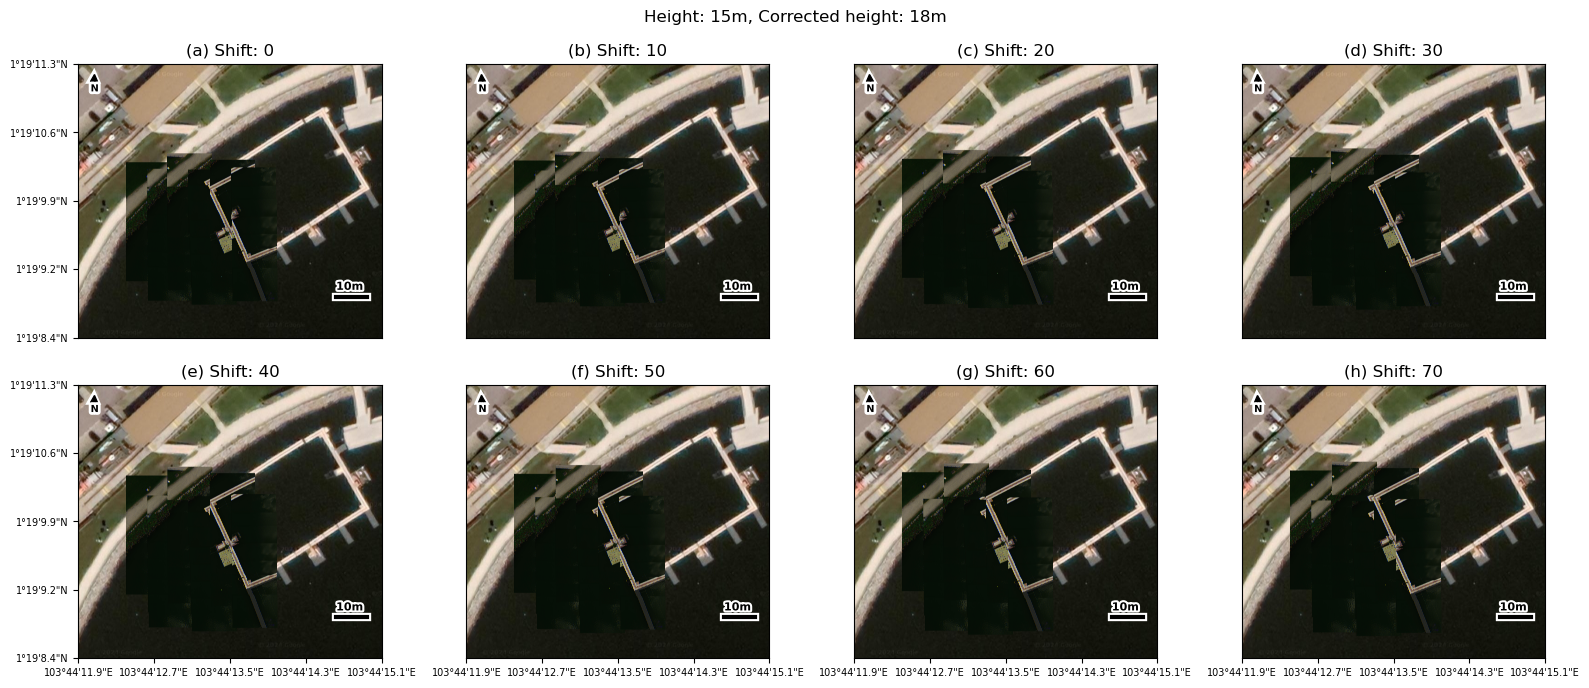

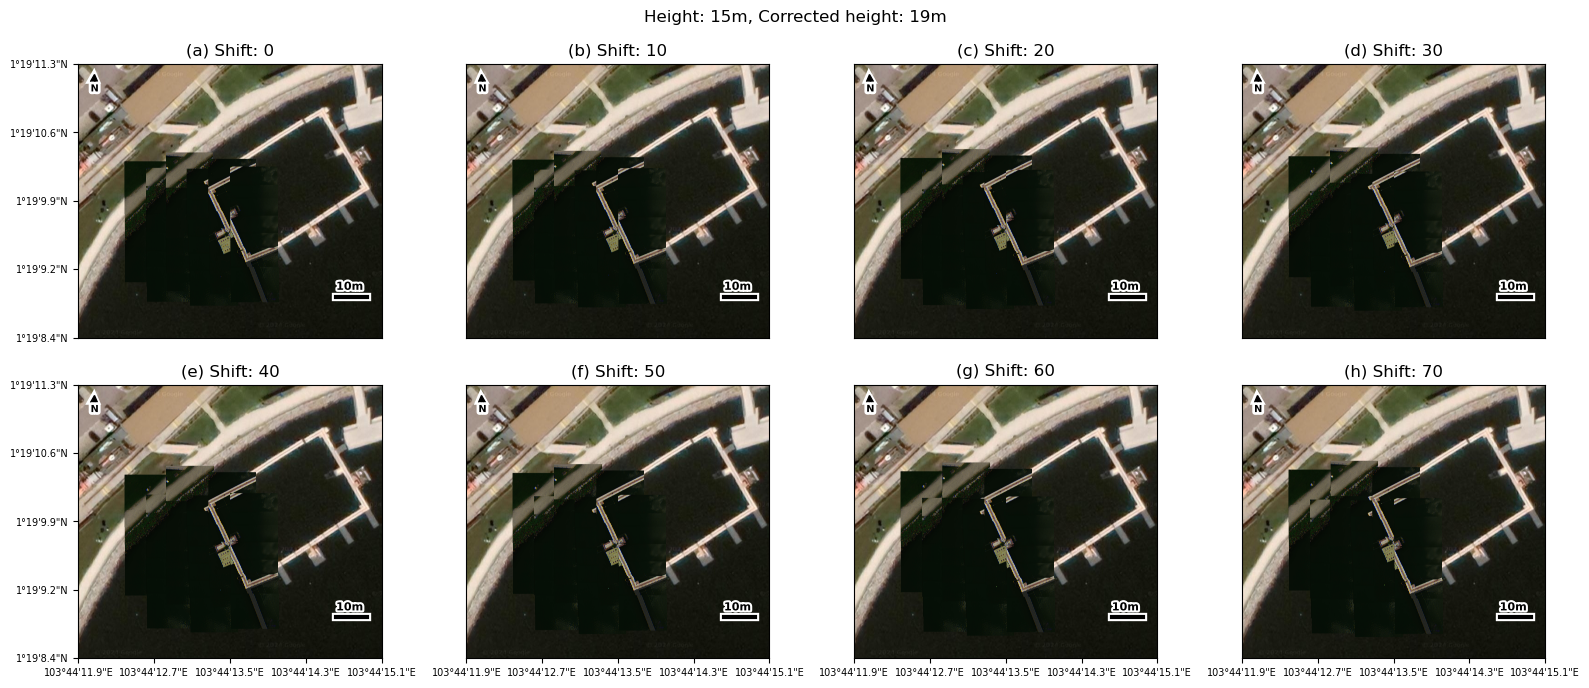

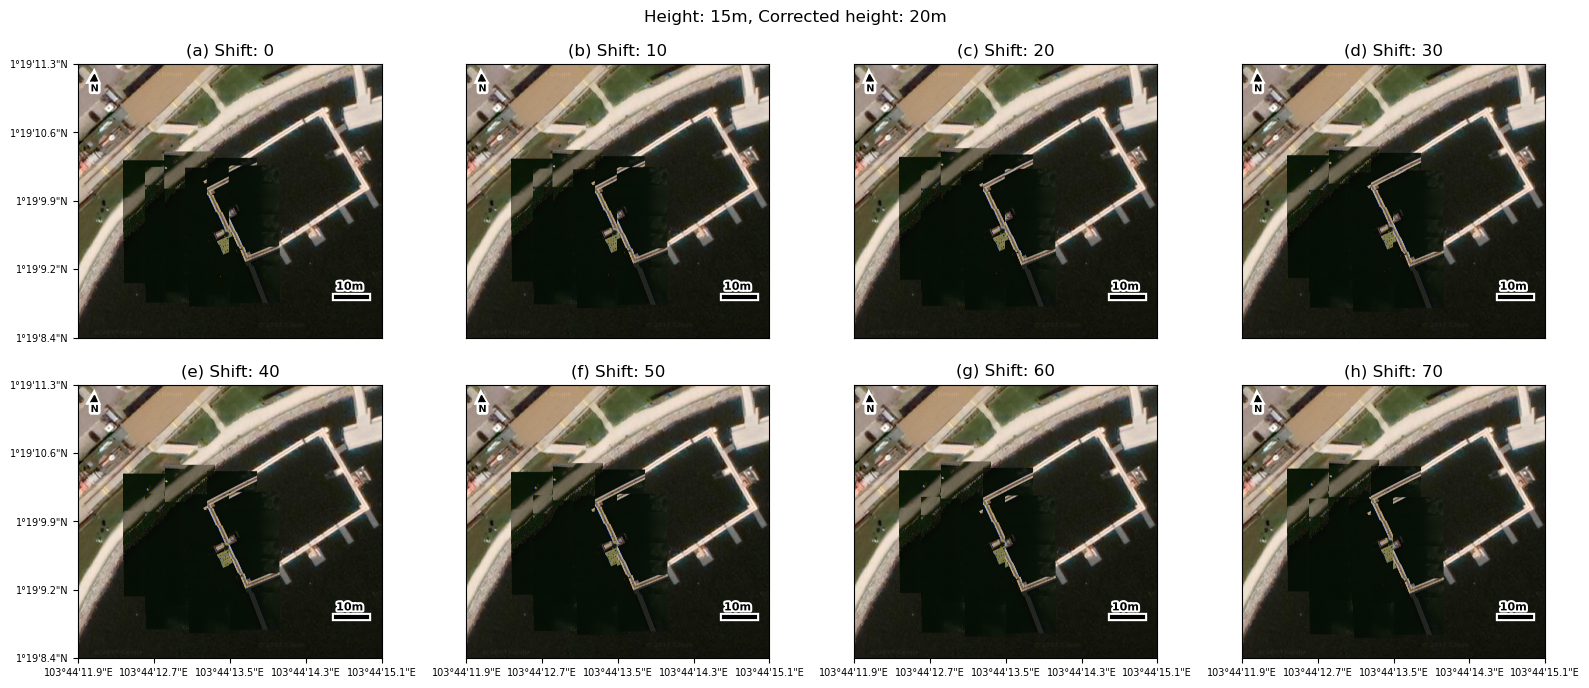

In [22]:
def modify_df(df_cropped, DEM_offset_height):
    #----------------append flight angle---------------------------------------------
    df_cropped.loc[:,['flight_angle']] = -df_cropped['dls-yaw']/np.pi*180
    # ---- instead of using yaw, use the heading of the UAV----------
    reclassify_angles = lambda x: -180 if x < -160 else 0
    reclassified_angles = [reclassify_angles(i) for i in df_cropped['flight_angle'].to_list()]
    df_cropped.loc[:,['flight_angle']] = reclassified_angles
    #-----------adjust UAV's altitude instead of using GPS's altitude reading--------
    df_cropped.loc[:,['altitude']] = df_cropped.loc[:,['altitude']] - DEM_offset_height
    return df_cropped

imagePath = r"D:\EPMC_flight\pandanRes\00angle_15H_50overlap"
canvas = np.asarray(Image.open(r"plots\aerialbot-2024-01-22T12.25.29-downward-1.319335,103.737142-2000x2000m-z20.jpg"))
sw_point = (1.319010, 103.736650)
ne_point = (1.319806, 103.737532)

BC = BatchCorrect(imagePath,dirName="test")
BC.main_shiftCoord(modify_df,ne_point,sw_point,canvas, calculate_correlation=True)

In [24]:

cc_list = mutils.load_pickle(r"D:\EPMC_flight\pandanRes\00angle_15H_50overlap\images\test\cc_list.ob")
cc_list

{15: {0: [('D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0010_1.jpg',
    -0.24658948167252204),
   ('D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0011_1.jpg',
    0.09899487215332567),
   ('D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0012_1.jpg',
    0.4702757197023957),
   ('D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0013_1.jpg',
    0.6772803009363648),
   ('D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0014_1.jpg',
    0.5146004901587135),
   ('D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0015_1.jpg',
    0.7044893304643636),
   ('D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0019_1.jpg',
    0.6106399958751567),
   ('D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0020_1.jpg',
    0.24236298013727836),
   ('D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0021_1.jpg',
    -0.04709197880525275

In [32]:
height_dict = dict()
for height, h_dict in cc_list.items():
    shift_dict = dict()
    for shift, shift_list in h_dict.items():
        cc_avg = np.mean([s[1] for s in shift_list])
        shift_dict[shift] = cc_avg
    height_dict[height] = shift_dict

[shift_d.values() for h, shift_d in height_dict.items()]
        # for (fp, cc) in shift_list:
        #     print(height,shift,os.path.basename(fp),cc)

[dict_values([0.32998668285411087, 0.3310251424942702, 0.32540565534030436, 0.3169331083905701, 0.30646267937067095, 0.29728705350611423, 0.29447947144249625, 0.2905216074078225]),
 dict_values([0.3497528138620373, 0.3521152548136635, 0.3485683380057034, 0.3378315314002785, 0.32499526073173446, 0.31522371524148507, 0.31032497460125563, 0.30145889254752994]),
 dict_values([0.3640260802305532, 0.3699422975546217, 0.3672226605854073, 0.35926452390906255, 0.3460482272070861, 0.3342885799186724, 0.32447793351557414, 0.3090666820131594]),
 dict_values([0.37419069144919137, 0.3793034695357113, 0.38030872054314585, 0.3754581175322412, 0.3636880943487677, 0.353349157958281, 0.3383104018702867, 0.3143052844552076]),
 dict_values([0.37992617604441736, 0.3848285582523469, 0.383829997420339, 0.38060129389072717, 0.37639117484481005, 0.3651618185460417, 0.3455248803464649, 0.31413388546377174]),
 dict_values([0.37761530484734274, 0.3859237936624853, 0.387588097867212, 0.38510850591927753, 0.38123078